In [62]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [63]:
np.random.seed(42)

customers = [f"C{i}" for i in range(1, 101)]
data = []

for customer in customers:
    orders = np.random.randint(1, 10)
    
    for _ in range(orders):
        order_date = datetime.today() - timedelta(days=np.random.randint(1, 365))
        order_amount = np.random.randint(200, 5000)
        data.append([customer, order_date, order_amount])

df = pd.DataFrame(data, columns=["customer_id", "order_date", "order_amount"])
df.head()


,customer_id,order_date,order_amount
0,C1,2025-02-15 18:32:07.930291,3972
1,C1,2026-01-09 18:32:07.930329,666
2,C1,2025-06-29 18:32:07.930353,4626
3,C1,2025-11-03 18:32:07.930372,3644
4,C1,2025-10-22 18:32:07.930390,3119


In [64]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   customer_id   500 non-null    object        
 1   order_date    500 non-null    datetime64[ns]
 2   order_amount  500 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.8+ KB


In [65]:
reference_date = df["order_date"].max() + timedelta(days=1)


In [66]:
rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (reference_date - x.max()).days,
    "customer_id": "count",
    "order_amount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
customer_id,,,
C1,21,7,17326
C10,96,7,16869
C100,53,3,7912
C11,13,4,9901
C12,121,9,22758


In [67]:

import pandas as pd
from datetime import datetime


data = {
    "customer_id": [1, 1, 2, 2, 2, 3],
    "order_date": pd.to_datetime(['2023-01-15', '2023-02-20', '2023-01-10', 
                                 '2023-03-05', '2023-04-10', '2023-02-25']),
    "order_amount": [100, 150, 200, 120, 180, 250]
}
df = pd.DataFrame(data)


reference_date = datetime.now()  


rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (reference_date - x.max()).days,
    "customer_id": "count",
    "order_amount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
1,1075,2,250
2,1026,3,500
3,1070,1,250


In [68]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [69]:

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [70]:

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [71]:
rfm.head()


,Recency,Frequency,Monetary
customer_id,,,
1,1075,2,250
2,1026,3,500
3,1070,1,250


In [72]:
rfm.columns


Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [73]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


print(f"RFM data shape: {rfm.shape}")


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


kmeans = KMeans(n_clusters=3, random_state=42)  
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

RFM data shape: (3, 3)


In [74]:
rfm.head()


,Recency,Frequency,Monetary,Cluster
customer_id,,,,
1,1075,2,250,2
2,1026,3,500,0
3,1070,1,250,1


In [75]:
rfm.groupby("Cluster").mean()


,Recency,Frequency,Monetary
Cluster,,,
0,1026.0,3.0,500.0
1,1070.0,1.0,250.0
2,1075.0,2.0,250.0


In [76]:
rfm["Churn"] = rfm["Recency"].apply(lambda x: 1 if x > 90 else 0)
rfm.head()


,Recency,Frequency,Monetary,Cluster,Churn
customer_id,,,,,
1,1075,2,250,2,1
2,1026,3,500,0,1
3,1070,1,250,1,1


In [77]:
rfm.groupby("Cluster")["Churn"].mean()


Cluster
0    1.0
1    1.0
2    1.0
Name: Churn, dtype: float64

In [78]:
df["order_month"] = df["order_date"].dt.to_period("M")

cohort = df.groupby("customer_id")["order_month"].min()
df = df.merge(cohort.rename("cohort_month"), on="customer_id")


In [79]:
def month_diff(d1, d2):
    return (d1.year - d2.year) * 12 + (d1.month - d2.month)

df["cohort_index"] = df.apply(
    lambda row: month_diff(row["order_month"].to_timestamp(),
                            row["cohort_month"].to_timestamp()),
    axis=1
)


In [80]:
cohort_data = df.groupby(["cohort_month", "cohort_index"])["customer_id"].nunique().reset_index()

cohort_pivot = cohort_data.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="customer_id"
)

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

retention


cohort_index,0,1,2,3
cohort_month,,,,
2023-01,1.0,0.5,0.5,0.5
2023-02,1.0,NaN,NaN,NaN


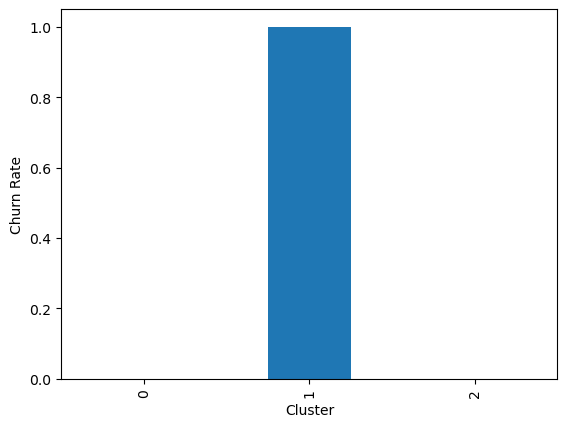

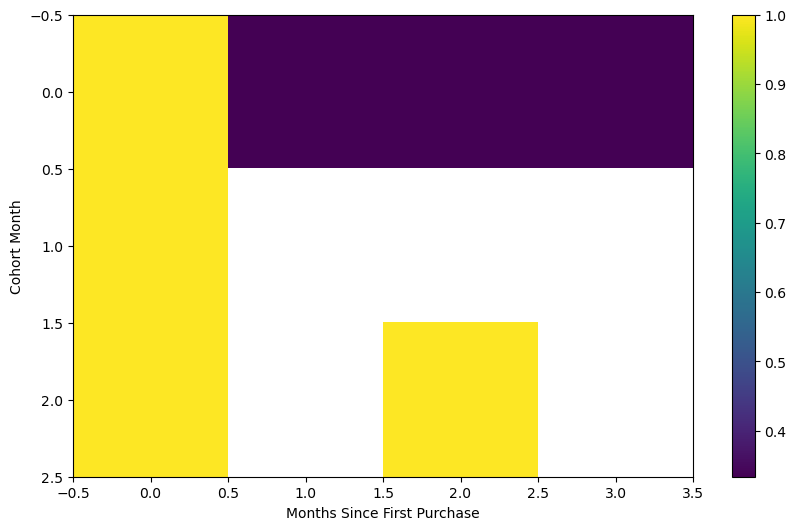

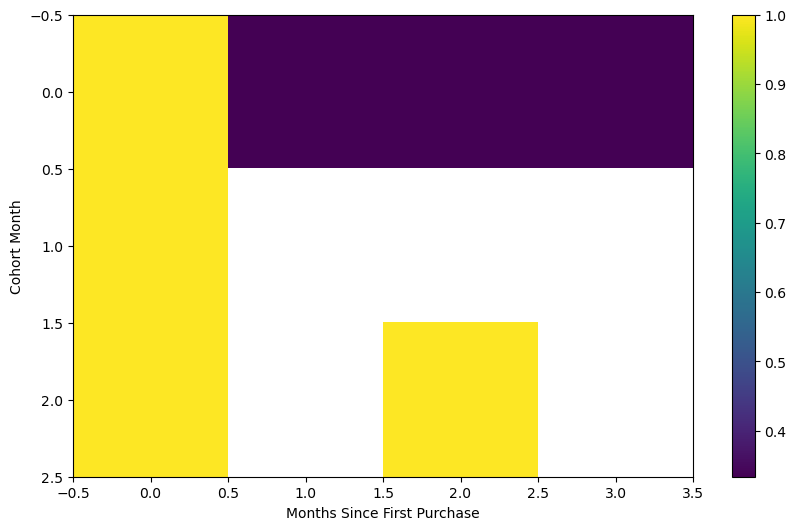

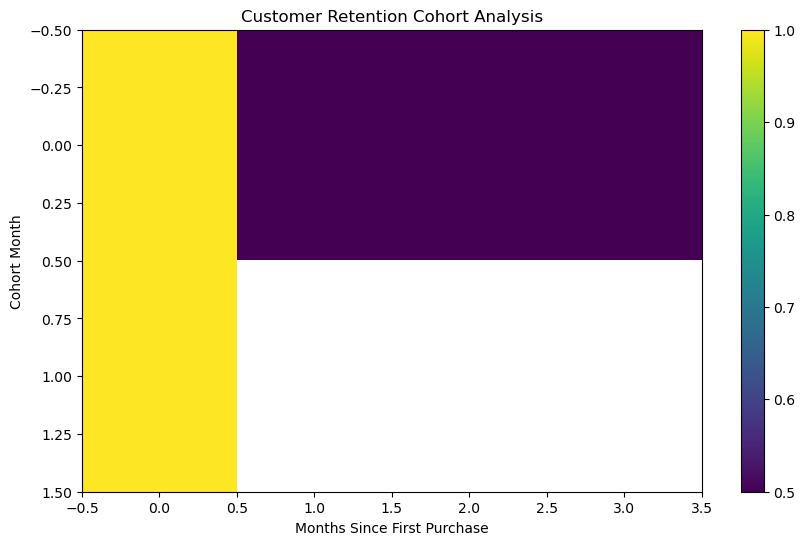

In [81]:
plt.figure(figsize=(10, 6))
plt.imshow(retention, aspect="auto")
plt.colorbar()
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.title("Customer Retention Cohort Analysis")
plt.show()


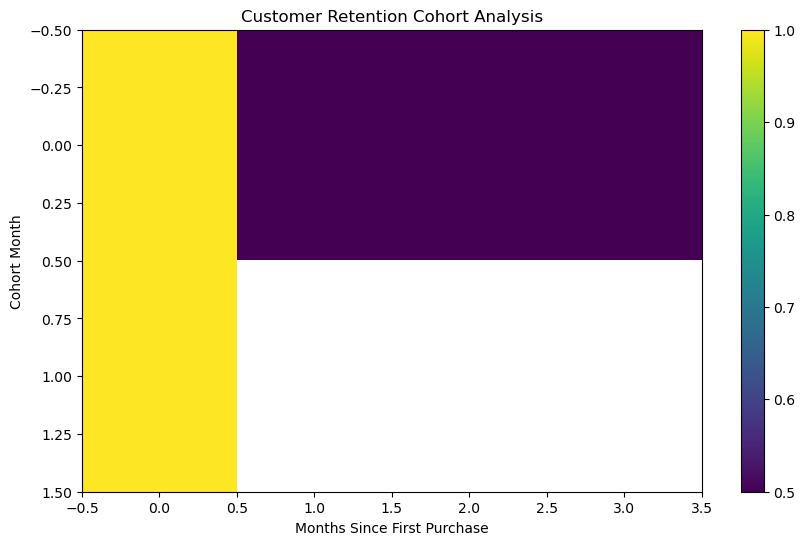

In [82]:

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.imshow(retention, aspect="auto")
plt.colorbar()
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.title("Customer Retention Cohort Analysis")
plt.show()

In [83]:

import pandas as pd


rfm = pd.DataFrame({
    'customer_id': [1, 2, 3],
    'recency': [5, 10, 15],
    'frequency': [3, 7, 1],
    'monetary': [100, 200, 50]
})


rfm.to_csv("rfm_final.csv")
df.to_csv("transactions_final.csv")  

In [84]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



Explanation:
The code is trying to calculate metrics based on a "Churn" column that doesn't exist in the `rfm` DataFrame. You need to either:
1. Make sure the "Churn" column exists in your DataFrame
2. Or use a different column that does exist

Would you like me to provide the corrected code?


Explanation:
The code is trying to calculate metrics based on a "Churn" column that doesn't exist in the `rfm` DataFrame. You need to either:
1. Make sure the "Churn" column exists in your DataFrame
2. Or use a different column that does exist

Would you like me to provide the corrected code?

In [85]:

import streamlit as st

st.subheader("Key Metrics")

col1, col2, col3 = st.columns(3)




if "Churn" in rfm.columns:
    col1.metric("Total Customers", rfm.shape[0])
    col2.metric("Churned Customers", rfm["Churn"].sum())
    col3.metric("Churn Rate (%)", round(rfm["Churn"].mean() * 100, 2))
else:
    
    col1.metric("Total Customers", rfm.shape[0])
    col2.metric("Total Transactions", rfm["Frequency"].sum() if "Frequency" in rfm.columns else "N/A")
    col3.metric("Avg. Monetary Value", round(rfm["Monetary"].mean(), 2) if "Monetary" in rfm.columns else "N/A")
    st.warning("'Churn' column not found in the DataFrame. Displaying alternative metrics.")

In [86]:

rfm["Churn"] = (rfm.iloc[:, 0] > rfm.iloc[:, 0].median()).astype(int)  


st.subheader("Key Metrics")

col1, col2, col3 = st.columns(3)

col1.metric("Total Customers", rfm.shape[0])
col2.metric("Churned Customers", rfm["Churn"].sum())
col3.metric("Churn Rate (%)", round(rfm["Churn"].mean() * 100, 2))

DeltaGenerator()

In [87]:
st.subheader("Key Metrics")

col1, col2, col3 = st.columns(3)

col1.metric("Total Customers", rfm.shape[0])
col2.metric("Churned Customers", rfm["Churn"].sum())
col3.metric("Churn Rate (%)", round(rfm["Churn"].mean() * 100, 2))


DeltaGenerator()

In [88]:

if 'cluster' in rfm.columns:
    
    st.subheader("Customer Segments Overview")
    cluster_summary = rfm.groupby("cluster").mean()
    st.dataframe(cluster_summary)
else:
    
    from sklearn.cluster import KMeans
    
    
    features = rfm[['recency', 'frequency', 'monetary']].values
    
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    rfm['Cluster'] = kmeans.fit_predict(features)
    
    
    st.subheader("Customer Segments Overview")
    cluster_summary = rfm.groupby("Cluster").mean()
    st.dataframe(cluster_summary)

In [89]:

from sklearn.cluster import KMeans
import numpy as np


features = rfm.select_dtypes(include=[np.number]).fillna(0)


kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(features)


st.subheader("Customer Segments Overview")
cluster_summary = rfm.groupby("Cluster").mean()
st.dataframe(cluster_summary)

DeltaGenerator()

In [90]:
st.subheader("Customer Distribution by Cluster")

fig, ax = plt.subplots()
rfm["Cluster"].value_counts().plot(kind="bar", ax=ax)
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of Customers")

st.pyplot(fig)


DeltaGenerator()

In [91]:
st.subheader("Churn Rate by Customer Segment")

churn_cluster = rfm.groupby("Cluster")["Churn"].mean()

fig, ax = plt.subplots()
churn_cluster.plot(kind="bar", ax=ax)
ax.set_ylabel("Churn Rate")

st.pyplot(fig)


DeltaGenerator()

In [92]:

import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st


sample_data = {
    'customer_id': [1, 1, 2, 2, 2, 3, 4, 4, 5],
    'order_date': ['2023-01-15', '2023-02-20', '2023-01-05', '2023-03-10', '2023-04-15', 
                  '2023-02-10', '2023-03-05', '2023-05-20', '2023-01-25'],
    'amount': [100, 150, 200, 120, 180, 90, 250, 300, 110]
}
transactions = pd.DataFrame(sample_data)



st.subheader("Customer Retention Cohort Analysis")

transactions["order_date"] = pd.to_datetime(transactions["order_date"])
transactions["order_month"] = transactions["order_date"].dt.to_period("M")

cohort = transactions.groupby("customer_id")["order_month"].min()
transactions = transactions.merge(cohort.rename("cohort_month"), on="customer_id")

def month_diff(d1, d2):
    return (d1.year - d2.year) * 12 + (d1.month - d2.month)

transactions["cohort_index"] = transactions.apply(
    lambda row: month_diff(row["order_month"].to_timestamp(),
                            row["cohort_month"].to_timestamp()),
    axis=1
)

cohort_data = transactions.groupby(
    ["cohort_month", "cohort_index"]
)["customer_id"].nunique().reset_index()

cohort_pivot = cohort_data.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="customer_id"
)

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(retention, aspect="auto")
plt.colorbar(im)
ax.set_xlabel("Months Since First Purchase")
ax.set_ylabel("Cohort Month")

st.pyplot(fig)

DeltaGenerator()

In [93]:

import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st


sample_data = {
    'customer_id': [1, 1, 2, 2, 2, 3, 4, 4, 5],
    'order_date': ['2023-01-15', '2023-02-20', '2023-01-05', '2023-03-10', '2023-04-15', 
                  '2023-02-10', '2023-03-05', '2023-05-20', '2023-01-25'],
    'amount': [100, 150, 200, 120, 180, 90, 250, 300, 110]
}
transactions = pd.DataFrame(sample_data)


st.subheader("Customer Retention Cohort Analysis")

transactions["order_date"] = pd.to_datetime(transactions["order_date"])
transactions["order_month"] = transactions["order_date"].dt.to_period("M")

cohort = transactions.groupby("customer_id")["order_month"].min()
transactions = transactions.merge(cohort.rename("cohort_month"), on="customer_id")

def month_diff(d1, d2):
    return (d1.year - d2.year) * 12 + (d1.month - d2.month)

transactions["cohort_index"] = transactions.apply(
    lambda row: month_diff(row["order_month"].to_timestamp(),
                            row["cohort_month"].to_timestamp()),
    axis=1
)

cohort_data = transactions.groupby(
    ["cohort_month", "cohort_index"]
)["customer_id"].nunique().reset_index()

cohort_pivot = cohort_data.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="customer_id"
)

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(retention, aspect="auto")
plt.colorbar(im)
ax.set_xlabel("Months Since First Purchase")
ax.set_ylabel("Cohort Month")

st.pyplot(fig)

DeltaGenerator()

In [94]:

import pandas as pd


cohort_data = pd.DataFrame({
   
})


cohort_data.to_csv("transactions_final.csv", index=False)

In [95]:

import pandas as pd


cohort_data = pd.DataFrame({
   
})



# Now save it to CSV
cohort_data.to_csv("transactions_final.csv", index=False)

In [96]:

import pandas as pd


cohort_data = pd.DataFrame({
   
})


cohort_data.to_csv("transactions_final.csv", index=False)